In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [ ]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(229),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(229),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', pretrained=False)
model.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1), stride=(1,1))
# fine tuning

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [ ]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [ ]:
model = model.to(device)
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 1.1005, acc: 0.3433
Duration :57.7475962638855 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 1.0986, acc: 0.3451
Duration :58.60934901237488 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 1.0982, acc: 0.3414
Duration :59.93743085861206 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 1.0986, acc: 0.3418
Duration :60.114094495773315 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 1.0985, acc: 0.3432
Duration :60.37300968170166 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 1.0984, acc: 0.3458
Duration :59.847333669662476 seconds
---------------------

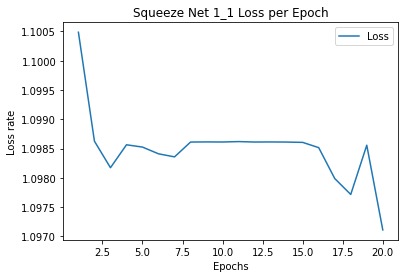

In [ ]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("Squeeze Net 1_1 Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
print(lossLine)

[1.1004856261749858, 1.0986259893876236, 1.098173138728645, 1.0985644476140772, 1.0985252537577568, 1.0984103754728487, 1.0983581340115962, 1.0986111852869633, 1.0986134549842734, 1.0986119244484491, 1.098619313276966, 1.0986114253737982, 1.098612818775458, 1.0986109938102586, 1.0986054678021469, 1.0985157416302374, 1.097988699400764, 1.097716561186539, 1.0985572404302053, 1.0971113629544866]


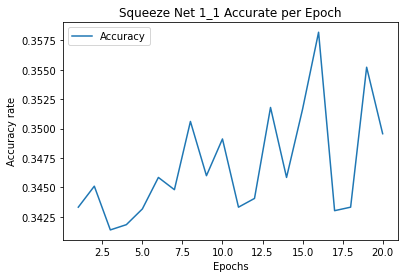

In [ ]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("Squeeze Net 1_1 Accurate per Epoch")
plt.legend()
plt.show()

In [ ]:
print(accLine)

[tensor(0.3433, device='cuda:0', dtype=torch.float64), tensor(0.3451, device='cuda:0', dtype=torch.float64), tensor(0.3414, device='cuda:0', dtype=torch.float64), tensor(0.3418, device='cuda:0', dtype=torch.float64), tensor(0.3432, device='cuda:0', dtype=torch.float64), tensor(0.3458, device='cuda:0', dtype=torch.float64), tensor(0.3448, device='cuda:0', dtype=torch.float64), tensor(0.3506, device='cuda:0', dtype=torch.float64), tensor(0.3460, device='cuda:0', dtype=torch.float64), tensor(0.3491, device='cuda:0', dtype=torch.float64), tensor(0.3433, device='cuda:0', dtype=torch.float64), tensor(0.3441, device='cuda:0', dtype=torch.float64), tensor(0.3518, device='cuda:0', dtype=torch.float64), tensor(0.3458, device='cuda:0', dtype=torch.float64), tensor(0.3516, device='cuda:0', dtype=torch.float64), tensor(0.3582, device='cuda:0', dtype=torch.float64), tensor(0.3430, device='cuda:0', dtype=torch.float64), tensor(0.3433, device='cuda:0', dtype=torch.float64), tensor(0.3552, device='cuda

In [ ]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

             0
0  1179.421387


In [ ]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.67      0.01      0.02       409
           1       0.23      1.00      0.37       367
           2       0.00      0.00      0.00       831

    accuracy                           0.23      1607
   macro avg       0.30      0.34      0.13      1607
weighted avg       0.22      0.23      0.09      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.23086496577473553

In [ ]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [ ]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 175 label: 1 pred: 1
vid: 179 label: 1 pred: 1
vid: 157 label: 1 pred: 1
vid: 188 label: 2 pred: 1
vid: 169 label: 0 pred: 1
vid: 195 label: 2 pred: 1
vid: 194 label: 1 pred: 1
vid: 185 label: 1 pred: 1
vid: 158 label: 0 pred: 1
vid: 171 label: 0 pred: 1
vid: 189 label: 1 pred: 1
vid: 164 label: 2 pred: 1
vid: 160 label: 2 pred: 1
vid: 193 label: 2 pred: 1
vid: 191 label: 0 pred: 1
vid: 161 label: 1 pred: 1
vid: 167 label: 2 pred: 1
vid: 192 label: 0 pred: 1
vid: 177 label: 0 pred: 1
vid: 180 label: 2 pred: 1
vid: 178 label: 0 pred: 1
vid: 181 label: 0 pred: 1
vid: 173 label: 2 pred: 1
vid: 172 label: 2 pred: 1
vid: 166 label: 1 pred: 1
vid: 183 label: 0 pred: 1
vid: 159 label: 1 pred: 1
vid: 176 label: 0 pred: 1
vid: 174 label: 1 pred: 1
vid: 186 label: 1 pred: 1
vid: 170 label: 2 pred: 1
vid: 165 label: 0 pred: 1
vid: 184 label: 2 pred: 1
vid: 163 label: 2 pred: 1
vid: 182 label: 2 pred: 1
vid: 187 label: 2 pred: 1
vid: 190 label: 1 pred: 1
vid: 162 label: 1 pred: 1
vid: 168 lab

In [ ]:
accuracy_score(y_true,y_pred)

0.3333333333333333